In [391]:
import rasterio
import rasterio.features
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.transform import from_bounds
from rasterio.vrt import WarpedVRT
from shapely.geometry import shape, mapping

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

import matplotlib.patches as mpatches

import fiona
from fiona.crs import from_epsg
import matplotlib.pyplot as plt

import geopandas as gpd 
import numpy as np
import pandas as pd

import os

In [392]:
base_dir = 'Results'

ssanto_crs = 'EPSG:3857'
target_crs = 'EPSG:2056'

# load city boundaries
city_boundaries_coordinate_crs  = gpd.read_file('Boundary/zurich_boundaries.shp')
city_boundaries = city_boundaries_coordinate_crs.to_crs(target_crs)


save_fig_dir = f"../Figures"

#load ssanto map
scenario = "100"

building_coverage = 0.05 # Number of buildings to implement GR in
total_emissions = 862000 # t CO2

if scenario=='Pan':
    em_reduction = 0.14 # 145% reduction in emissions
else:
    em_reduction = 0.075 #7.5% reduction in emissions


save = True
file_path = f"{base_dir}/{scenario}/ssanto-map.tif"

# Load and preprocess rasters 
We need all the different rasters on a projectable CRS and with the same sizes

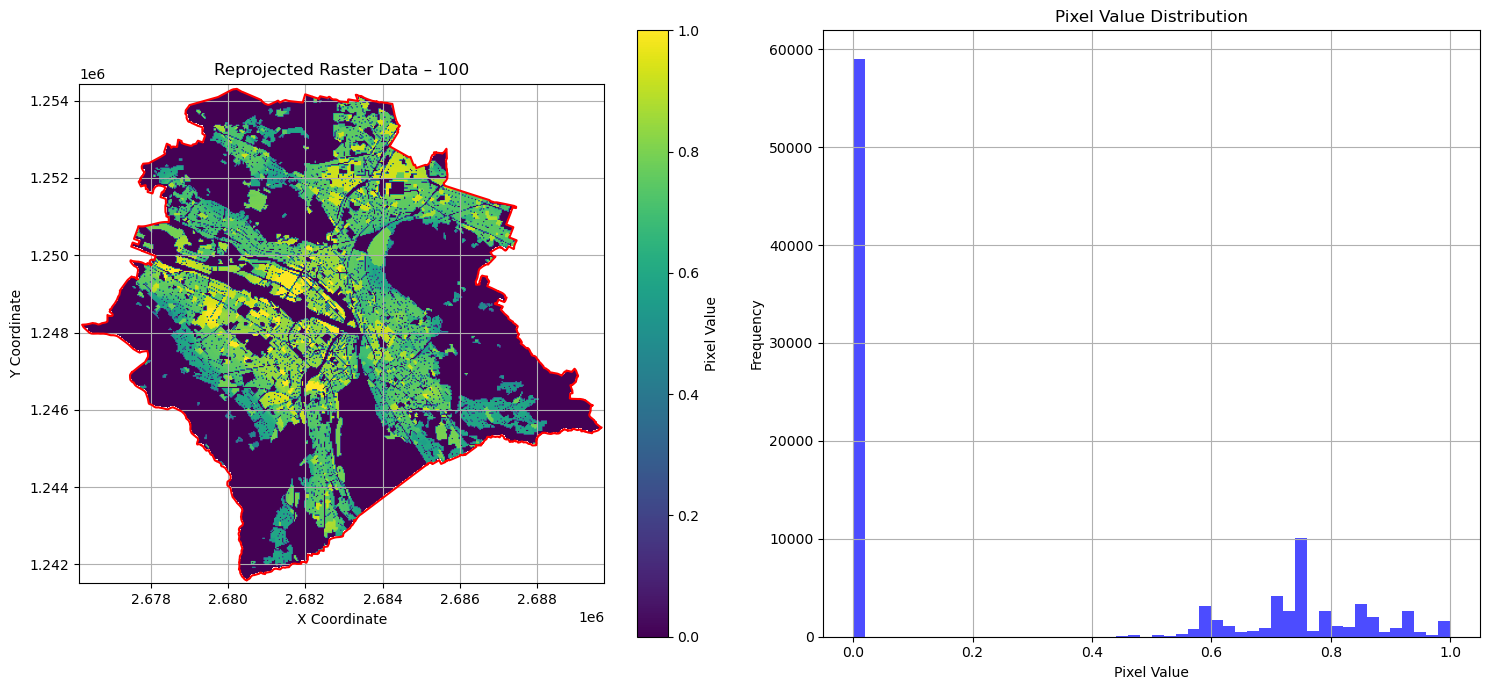

Raster Statistics 100
Original CRS: EPSG:3857
Target CRS: EPSG:2056
Original Resolution: (30.0, 30.0)
New Resolution: (30.00, 30.00) meters
Original Width x Height: 658 x 627
Reprojected Width x Height: 453 x 431
Bounds: BoundingBox(left=2676146.8836125354, bottom=1241509.5726028075, right=2689736.8836125354, top=1254439.5726028075)
Quantiles: [0.         0.         0.         0.74444842 0.848248   0.99912262]
Max and Min Values: 1.0, 0.0


In [393]:
with rasterio.open(file_path) as src:
    # Read source raster
    ssanto_raster = src.read(1)
    ssanto_width = src.width
    ssanto_height = src.height
    ssanto_res = src.res
    src_transform = src.transform

    # Calculate new transform and dimensions while keeping resolution intact
    dst_transform, width, height = calculate_default_transform(
        src.crs,
        target_crs,
        width=ssanto_width,
        height=ssanto_height,
        left=src.bounds.left,
        bottom=src.bounds.bottom,
        right=src.bounds.right,
        top=src.bounds.top,
        resolution=ssanto_res  # Maintain original resolution
    )

    tmp_raster = np.zeros((height, width), dtype=ssanto_raster.dtype)

    # Reproject raster
    reproject(
        source=ssanto_raster,
        destination=tmp_raster,
        src_transform=src_transform,
        src_crs=src.crs,
        dst_transform=dst_transform,
        dst_crs=target_crs,
        resampling=Resampling.nearest
    )

    # Mask the raster with city boundaries
    city_boundary = city_boundaries.geometry.unary_union

    mask = rasterio.features.geometry_mask(
        [mapping(city_boundary)],
        out_shape=(height, width),
        transform=dst_transform,
        invert=True
    )

    ssanto_raster = np.where(mask, tmp_raster, np.nan)
    ssanto_bounds = rasterio.coords.BoundingBox(
        left=dst_transform[2],
        bottom=dst_transform[5] + height * dst_transform[4],
        right=dst_transform[2] + width * dst_transform[0],
        top=dst_transform[5]
    )
    ssanto_extent = [
        dst_transform[2],
        dst_transform[2] + width * dst_transform[0],
        dst_transform[5] + height * dst_transform[4],
        dst_transform[5]
    ]

    # Plotting and statistics
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))

    # Plot reprojected raster data
    im = axs[0].imshow(ssanto_raster, cmap='viridis', extent=ssanto_extent)
    fig.colorbar(im, ax=axs[0], orientation='vertical', label='Pixel Value')
    axs[0].set_title(f'Reprojected Raster Data – {scenario}')
    axs[0].set_xlabel('X Coordinate')
    axs[0].set_ylabel('Y Coordinate')
    axs[0].grid(True)

    # Add city boundary to the plot
    city_boundaries.boundary.plot(color='red', ax=axs[0])

    # Plot pixel value distribution
    pixel_values = ssanto_raster.flatten()
    axs[1].hist(pixel_values, bins=50, color='blue', alpha=0.7)
    axs[1].set_title('Pixel Value Distribution')
    axs[1].set_xlabel('Pixel Value')
    axs[1].set_ylabel('Frequency')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

    # Display raster statistics
    print("Raster Statistics", scenario)
    print(f"Original CRS: {src.crs}")
    print(f"Target CRS: {target_crs}")
    print(f"Original Resolution: {ssanto_res}")
    print(f"New Resolution: ({dst_transform[0]:.2f}, {abs(dst_transform[4]):.2f}) meters")
    print(f"Original Width x Height: {ssanto_width} x {ssanto_height}")
    print(f"Reprojected Width x Height: {width} x {height}")
    print(f"Bounds: {ssanto_bounds}")
    print(f"Quantiles: {np.nanquantile(pixel_values, [0.1, 0.25, 0.5, 0.75, 0.9, 0.99])}")
    print(f"Max and Min Values: {np.nanmax(pixel_values)}, {np.nanmin(pixel_values)}")


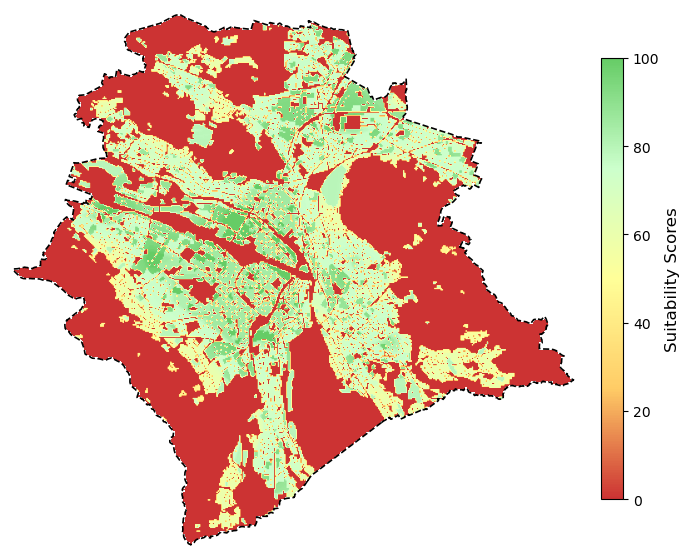

In [394]:
from matplotlib.colors import LinearSegmentedColormap

# Custom continuous colormap with softer red-to-green transition
colors = [
    (0.8, 0.2, 0.2),  # Soft red
    (1.0, 0.8, 0.4),  # Orange
    (1.0, 1.0, 0.6),  # Yellow
    (0.8, 1.0, 0.8),  # Light green
    (0.4, 0.8, 0.4)   # Deep green
]
custom_cmap = LinearSegmentedColormap.from_list("soft_red_green", colors, N=256)

fig, ax = plt.subplots(figsize=(7, 7))  # Adjust figure size

# Plot the raster with the custom colormap
im = ax.imshow(ssanto_raster*100, cmap=custom_cmap, extent=ssanto_extent)

# Overlay city boundary
city_boundaries.boundary.plot(ax=ax, color='black', linewidth=1.2, linestyle="--")

# Remove grid and axes for a clean look
ax.axis('off')

# Add a colorbar with clear labeling
cbar = plt.colorbar(im, ax=ax, fraction=0.036, pad=0.04)
cbar.set_label('Suitability Scores', fontsize=12)
cbar.ax.tick_params(labelsize=10)



# Add a clean title
# ax.set_title("SSANTO Suitability", fontsize=18, weight='bold', pad=15)

# Ensure tight layout and save/show the figure
plt.tight_layout()
if save:
    plt.savefig(f'{base_dir}/{scenario}/ssanto-map.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
# plt.savefig(f"{save_fig_dir}/ssanto_suitability_example.png")
plt.show()


## Padding of other rasters

In [395]:
target_height = height
target_width = width
target_bounds = ssanto_bounds
target_resolution = (30.0, 30.0)

print("Target Dimensions:", target_width, target_height)
print("Target Bounds:", target_bounds)

# Function to pad a raster to match target dimensions
def pad_raster(raster_data, src_bounds, src_transform, target_bounds, target_width, target_height, pad_val=0):
    
    # Calculate padding in pixels
    left_pad = int((src_bounds.left - target_bounds.left) / target_resolution[0])
    right_pad = target_width - raster_data.shape[1] - left_pad
    top_pad = int((target_bounds.top - src_bounds.top) / target_resolution[1])
    bottom_pad = target_height - raster_data.shape[0] - top_pad

    print("Padding (top, bottom, left, right):", top_pad, bottom_pad, left_pad, right_pad)

     # Ensure no negative padding (sanity check)
    if any(pad < 0 for pad in [left_pad, right_pad, top_pad, bottom_pad]):
        raise ValueError(
            f"Negative padding encountered.\n"
            f"src_bounds={src_bounds}\n"
            f"target_bounds={target_bounds}\n"
            f"Padding => top={top_pad}, bottom={bottom_pad}, left={left_pad}, right={right_pad}"
        )

    # Pad the raster with zeros
    padded_raster = np.pad(
        raster_data,
        pad_width=((top_pad, bottom_pad), (left_pad, right_pad)),
        mode="constant",
        constant_values=pad_val,
    )

    # Update the transform to match the new extent
    padded_transform = from_bounds(*target_bounds, target_width, target_height)
    return padded_raster, padded_transform


Target Dimensions: 453 431
Target Bounds: BoundingBox(left=2676146.8836125354, bottom=1241509.5726028075, right=2689736.8836125354, top=1254439.5726028075)


Padding (top, bottom, left, right): 4 2 1 2
Padded Landcover Raster Statistics
CRS: EPSG:2056
Width: 453
Height: 431
Bounds: [2676146.8836125354, 2689736.8836125354, 1241509.5726028075, 1254439.5726028075]
Resolution: 30.0 -30.0
Weighted Average Value (Residential): 0.5149565760699781
Residential Area:  28.809 sq km
Industrial Area:  9.9657 sq km


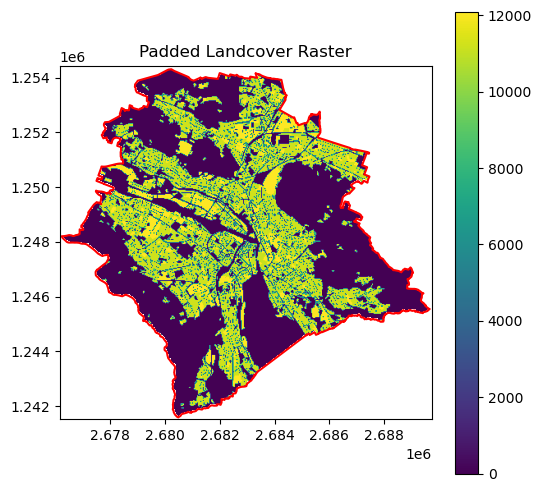

In [396]:
lulc_file = 'Landcover/res_ind_raster_30m.tif'

# Open the raster file and read the data
with rasterio.open(lulc_file) as src:
    # Read the raster data
    lulc_data = src.read(1)
    # Perform the padding to match target dimensions
    padded_lulc, new_lulc_transform = pad_raster(
        lulc_data, src.bounds, src.transform, target_bounds, target_width, target_height
    )
    # Mask the lulc raster with city boundaries
    mask = rasterio.features.geometry_mask(
        [mapping(city_boundary)],
        out_shape=(target_height, target_width),
        transform=new_lulc_transform,
        invert=True
    )
    # Apply the mask
    lulc_raster = np.where(mask, padded_lulc, np.nan)
    lulc_transform = new_lulc_transform
    lulc_extent = [
        lulc_transform[2],
        lulc_transform[2] + target_width * lulc_transform[0],
        lulc_transform[5] + target_height * lulc_transform[4],
        lulc_transform[5],
    ]

    # Extract CRS and shape after padding
    lulc_crs = src.crs
    lulc_shape = lulc_raster.shape

# Display statistics
print("Padded Landcover Raster Statistics")
print("CRS:", lulc_crs)
print(f"Width: {lulc_shape[1]}")
print(f"Height: {lulc_shape[0]}")
print("Bounds:", lulc_extent)
print("Resolution:", lulc_transform[0], lulc_transform[4])

# Calculate residential and industrial areas in square kilometers
res_area = np.sum((lulc_raster > 0) & (lulc_raster < 12100)) * target_resolution[0] * target_resolution[1] / 1e6
ind_area = np.sum(lulc_raster == 12100) * target_resolution[0] * target_resolution[1] / 1e6

# Define a mapping from code to value
code_to_value = {
    11100: 0.9,
    11210: 0.65,
    11220: 0.4,
    11230: 0.2,
    11240: 0.05,
    11300: 0.01
}

# Calculate the weighted by area average value of the landcover raster from the categories in the map (residential)
weighted_sum = 0
total_weight = 0

for code, value in code_to_value.items():
    area = np.sum(lulc_raster == code) * target_resolution[0] * target_resolution[1] / 1e6  # in sq km
    weighted_sum += area * value
    total_weight += area

weighted_average_value = weighted_sum / total_weight 
print("Weighted Average Value (Residential):", weighted_average_value)

print("Residential Area: ", res_area, "sq km")
print("Industrial Area: ", ind_area, "sq km")

# Plot the padded raster
fig, ax = plt.subplots(figsize=(6, 6))
city_boundaries.boundary.plot(color='red', ax=ax)
ax.imshow(lulc_raster, cmap='viridis', extent=lulc_extent)
plt.colorbar(ax.imshow(lulc_raster, cmap='viridis', extent=lulc_extent), ax=ax)
ax.set_title('Padded Landcover Raster')
plt.show()


Original sum: 168783.9
Padding (top, bottom, left, right): 4 3 2 3
Padded Emission Raster Statistics
CRS: EPSG:2056
Width: 453
Height: 431
Bounds: [2676146.8836125354, 2689736.8836125354, 1241509.5726028075, 1254439.5726028075]
Resolution: 30.0 -30.0
Total emissions: 861999.94
Quantiles: [13.80991451 18.50851631 19.62820816 22.10804939 24.16707611 26.12676239]
Max and Min Values: 26.131617 11.659413


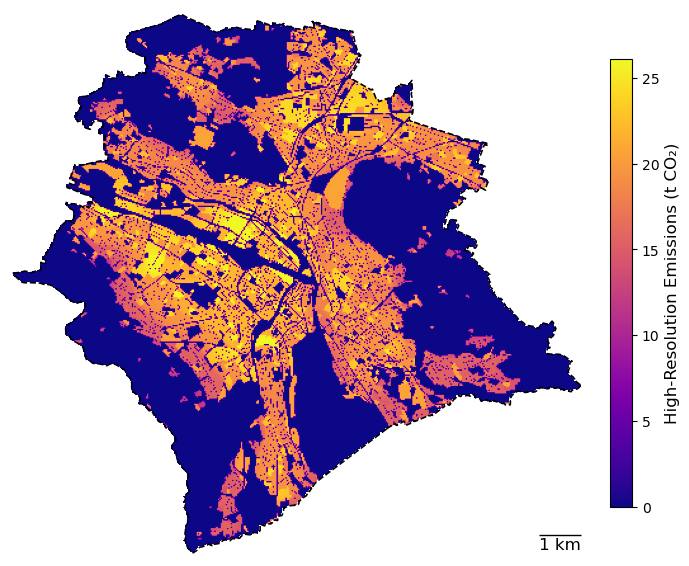

In [397]:
# em_file = f"emissions/res_com_emissions_30m_resampled.tif"
# em_file = f"emissions/res_high_res_30m_resampled.tif"
em_file = f"emissions/res_ind_high_res.tif"

# Open the raster file and read the data
with rasterio.open(em_file) as src:
    # Read the raster data
    em_raster = src.read(1)
    print("Original sum:", np.nansum(em_raster))
    # Perform the padding to match target dimensions
    padded_em, new_em_transform = pad_raster(
        em_raster, src.bounds, src.transform, target_bounds, target_width, target_height, pad_val=np.nan
    )
    # Assign the padded raster and updated transform
    em_raster = padded_em
    em_transform = new_em_transform
    em_extent = [
        em_transform[2],
        em_transform[2] + target_width * em_transform[0],
        em_transform[5] + target_height * em_transform[4],
        em_transform[5],
    ]

    # Extract CRS and shape after padding
    em_crs = src.crs
    em_shape = em_raster.shape

    # Scale according to the total city's emissions
    scale_factor = total_emissions / np.nansum(em_raster)
    em_raster *= scale_factor


# Display statistics
print("Padded Emission Raster Statistics")
print("CRS:", em_crs)
print(f"Width: {em_shape[1]}")
print(f"Height: {em_shape[0]}")
print("Bounds:", em_extent)
print("Resolution:", em_transform[0], em_transform[4])
print("Total emissions:", np.nansum(em_raster))
# Exclude zero values for quantile and min/max calculations
non_zero_values = em_raster[em_raster > 0]

print("Quantiles:", np.nanquantile(non_zero_values, [0.01, 0.25, 0.5, 0.75, 0.9, 0.99]))
print("Max and Min Values:", np.nanmax(non_zero_values), np.nanmin(non_zero_values))

# Plot the padded raster
fig, ax = plt.subplots(figsize=(7, 7), facecolor='white')

# Plot the emission raster
em_display = ax.imshow(em_raster, cmap='plasma', alpha=1, extent=em_extent)

# Add city boundaries to the plot
city_boundaries.boundary.plot(color='black', linewidth=1.2, linestyle="--", ax=ax)

# Add colorbar for the emission raster
cbar = plt.colorbar(em_display, ax=ax, fraction=0.036, pad=0.04)
cbar.set_label('High-Resolution Emissions (t CO₂)', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Add a clean title
ax.set_xlabel('X Coordinate', fontsize=12, weight='bold')
ax.set_ylabel('Y Coordinate', fontsize=12, weight='bold')

# Remove grid and axes for a clean look
ax.axis('off')

# Add a scale bar
fontprops = fm.FontProperties(size=12)
scalebar = AnchoredSizeBar(ax.transData,
                           1000, '1 km', 'lower right', 
                           pad=0.1,
                           color='black',
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)

ax.add_artist(scalebar)

# Ensure tight layout and save/show the figure
plt.tight_layout()
if save:
    plt.savefig(f'{base_dir}/{scenario}/padded_emission_raster.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()


# Get areas with highest suitability available from SSANTO

Chosen threshold: 0.9380207657814026
Green roof area: 1.94 km^2
Percentage of landcover selected: 5.00%
Suitability values selected range: 0.94 - 1.00


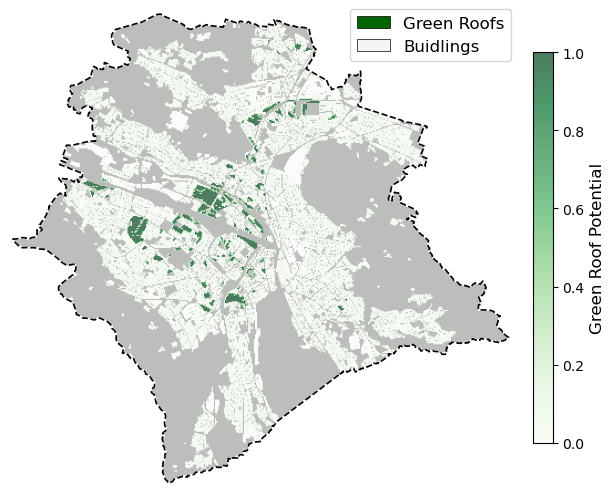

In [398]:
# Step 1: Mask ssanto_raster using lulc_raster
masked_ssanto = np.where(lulc_raster > 0, ssanto_raster, np.nan)

# Step 2: Calculate the threshold based on the top 5% of the landcover
threshold = np.nanquantile(masked_ssanto, 1 - building_coverage)

# Step 3: Apply both masks in one step (landcover > 0 and suitability >= threshold)
green_roofs = (lulc_raster > 0) & (masked_ssanto >= threshold)

# Step 4: Mask outside the boundary of the city
city_mask = rasterio.features.geometry_mask(
    [mapping(city_boundary)],
    out_shape=green_roofs.shape,
    transform=lulc_transform,
    invert=True,
)

# Extract suitability values for selected areas
selected_suitability_values = masked_ssanto[green_roofs]

green_roofs = np.where(city_mask, green_roofs, np.nan)

# Calculate total area of selected green roofs
intersection_area = np.nansum(green_roofs) * ssanto_res[0] * ssanto_res[1]  # Multiply by resolution
total_landcover_area = np.sum(lulc_raster > 0) * ssanto_res[0] * ssanto_res[1]

# Output results
print(f"Chosen threshold: {threshold}")
print(f"Green roof area: {intersection_area / 1e6:.2f} km^2")
print(f"Percentage of landcover selected: {intersection_area / total_landcover_area * 100:.2f}%")
print(f"Suitability values selected range: {np.nanmin(selected_suitability_values):.2f} - {np.nanmax(selected_suitability_values):.2f}")

# Visualization
fig, ax = plt.subplots(figsize=(7, 7))

# Plot the landcover raster
landcover_display = ax.imshow(lulc_raster, cmap='gray', alpha=0.8, extent=lulc_extent)

# Overlay the green roofs
green_roofs_display = ax.imshow(green_roofs, cmap='Greens', alpha=0.7, extent=lulc_extent)

# Add city boundaries to the plot
city_boundaries.boundary.plot(color='black', linewidth=1.2, linestyle="--", ax=ax)

# Add legend
legend_patches = [
    mpatches.Patch(facecolor='darkgreen', edgecolor='black', label='Green Roofs', linewidth=0.5),
    mpatches.Patch(facecolor='whitesmoke', edgecolor='black', label='Buidlings', linewidth=0.5)
]
# Adjust the legend location to place it outside the map area
ax.legend(
    handles=legend_patches,
    loc='upper right',                # Adjust location
    # bbox_to_anchor=(0.7, 0.05),        # Place the legend outside the plot
    fontsize=12,                     # Font size
    borderaxespad=0.                # Reduce padding
)


# Add colorbar for the green roofs overlay
cbar = plt.colorbar(green_roofs_display, ax=ax, fraction=0.036, pad=0.04)
cbar.set_label('Green Roof Potential', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Add a clean title
ax.set_xlabel('X Coordinate', fontsize=12, weight='bold')
ax.set_ylabel('Y Coordinate', fontsize=12, weight='bold')
ax.set_facecolor('white')

# Remove grid and axes for a clean look
ax.axis('off')

# Ensure layout and save/show the figure
plt.savefig(f'{base_dir}/{scenario}/green_roofs_potential.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()


# Emission Savings: Methodology 1
Take the area implemented, multiply by carbon sequestration factors, as well as calculate energy saved in kWh. Then use Zurich carbon grid footprint to calcualte the emissions saved from energy reductions. 

In [399]:
energy_save_rate = 4  # kWh/m^2/year
carbon_seq_rate = 1.8  # kg/m^2/year
roof_coverage = 0.6 # 60% of the roof area is covered by green roofs
carbon_intensity = 0.184 # kgCO2/kWh

total_res_emissions = np.nansum(em_raster) # tCO2/year
print(f"Total residential emissions: {total_res_emissions:.2f} tCO2/year")

Total residential emissions: 861999.94 tCO2/year


In [400]:
green_roof_area = intersection_area * roof_coverage

energy_saved = green_roof_area * energy_save_rate  # kWh/year
carbon_saved_energy = energy_saved * carbon_intensity / 1e3  # tCO2/year
carbon_seq =  (green_roof_area * carbon_seq_rate) / 1e3 # tCO2/year

In [401]:
print(f"Green roof area: {green_roof_area/1e6:.2f} km^2")
print(f"Energy saved: {energy_saved/1e3:.2f} MWh/year")

print(f"Carbon saved from energy: {carbon_saved_energy:.2f} tCO2/year")
print(f"Carbon sequestered: {carbon_seq:.2f} tCO2/year")

Green roof area: 1.16 km^2
Energy saved: 4654.80 MWh/year
Carbon saved from energy: 856.48 tCO2/year
Carbon sequestered: 2094.66 tCO2/year


In [402]:
print(f"Carbon sequestered percentage: {carbon_seq / total_res_emissions * 100:.2f}%")
print(f"Carbon saved from energy percentage: {carbon_saved_energy / total_res_emissions * 100:.2f}%")
print(f"Total carbon saved: {carbon_saved_energy + carbon_seq:.2f} tCO2/year")
print(f"Total carbon saved percentage: {(carbon_saved_energy + carbon_seq) / total_res_emissions * 100:.2f}%")

Carbon sequestered percentage: 0.24%
Carbon saved from energy percentage: 0.10%
Total carbon saved: 2951.14 tCO2/year
Total carbon saved percentage: 0.34%


# Emission Savings: Methodology 2
Here we see the location where there is a green rooftop implemented, and we compute a reduction of emissions in that specific location using the emission raster values and the emission reduction percentages.

In [403]:
roof_coverage = 0.6 # 60% of the roof area is covered by green roofs

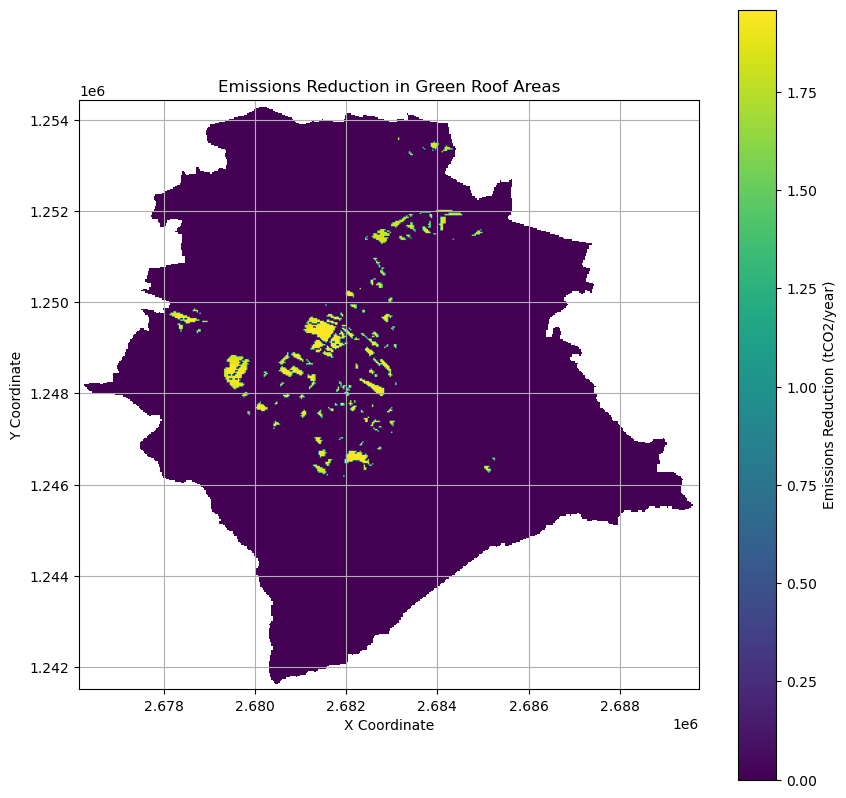

In [404]:
# Calculate emissions reduced in green roof areas
# Mask emissions raster to only include green roof areas
mask_green_roofs_ems = em_raster * green_roofs

# Apply the reduction percentage
reduced_emissions_energy = mask_green_roofs_ems * em_reduction

# Total emissions reduction (sum of reduced emissions across all cells)
carbon_saved_energy = np.nansum(reduced_emissions_energy)

# Save the reduced emissions raster to a new GeoTIFF file
output_file = f'Results/{scenario}/reduced_emissions.tif'
if save:
    with rasterio.open(
        output_file,
        'w',
        driver='GTiff',
        height=reduced_emissions_energy.shape[0],
        width=reduced_emissions_energy.shape[1],
        count=1,
        dtype=reduced_emissions_energy.dtype,
        crs=ssanto_crs,
        transform=src_transform,
    ) as dst:
        dst.write(reduced_emissions_energy, 1)

# Plot the reduced emissions
plt.figure(figsize=(10, 10))
plt.imshow(reduced_emissions_energy, cmap='viridis', extent=em_extent)
plt.colorbar(label='Emissions Reduction (tCO2/year)')
plt.title('Emissions Reduction in Green Roof Areas')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

# # save figure as image
# if save: 
#     plt.savefig(f'{base_dir}/{scenario}/reduced_emissions.png')


# Save results

In [405]:
total_reduced_emissions = round(carbon_saved_energy + carbon_seq, 2)
# total_res_emissions_rounded = round(total_res_emissions, 2)
# carbon_saved_energy_rounded = round(carbon_saved_energy, 2)
# carbon_seq_rounded = round(carbon_seq, 2)

# Display the result
print(f"Emissions reduced from energy by green roofs: {carbon_saved_energy:.2f} tons CO2/year")
print(f"Emissions reduced from carbon sequestration by green roofs: {carbon_seq:.2f} tons CO2/year")
print("Total emissions reduced by green roofs:", total_reduced_emissions, "tons CO2/year")
print("Total emissions reduced percentage:", round(total_reduced_emissions / total_res_emissions * 100, 2), "%")
print("Percentage reduction by energy:", round(carbon_saved_energy / total_res_emissions * 100, 2), "%")
print("Percentage reduction by carbon sequestration:", round(carbon_seq / total_res_emissions * 100, 2), "%")

Emissions reduced from energy by green roofs: 4067.09 tons CO2/year
Emissions reduced from carbon sequestration by green roofs: 2094.66 tons CO2/year
Total emissions reduced by green roofs: 6161.75 tons CO2/year
Total emissions reduced percentage: 0.71 %
Percentage reduction by energy: 0.47 %
Percentage reduction by carbon sequestration: 0.24 %


In [406]:
result_dir = f"Results/{scenario}"

results_file = f"{result_dir}/results_{building_coverage}.csv"

# Save the results to a csv formatted, with the following columns:
# - Emissions reduced from energy
# - Emissions reduced from carbon sequestration
# - Total emissions reduced
# - Total emissions reduced percentage
# - Percentage reduction by energy
# - Percentage reduction by carbon sequestration

results = pd.DataFrame({
    "Emissions reduced from energy": [carbon_saved_energy],
    "Emissions reduced from carbon sequestration": [carbon_seq],
    "Total emissions reduced": [total_reduced_emissions],
    "Total emissions reduced percentage": [round(total_reduced_emissions / total_res_emissions * 100, 2)],
    "Percentage reduction by energy": [round(carbon_saved_energy / total_res_emissions * 100, 2)],
    "Percentage reduction by carbon sequestration": [round(carbon_seq / total_res_emissions * 100, 2)]
})

results.to_csv(results_file, index=False)

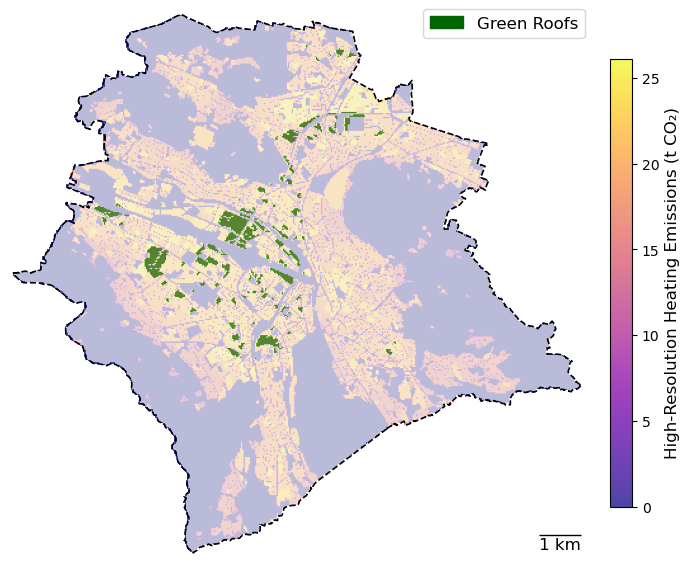

In [407]:
fig, ax = plt.subplots(figsize=(7, 7), facecolor='white')

# Plot the emission raster
em_display = ax.imshow(em_raster, cmap='plasma', alpha=0.75, extent=em_extent)

# Overlay the green roofs with a stronger color
green_roofs_display = ax.imshow(green_roofs, cmap='Greens', alpha=0.65, extent=em_extent)

# Add city boundaries to the plot
city_boundaries.boundary.plot(color='black', linewidth=1.2, linestyle="--", ax=ax)

# Add colorbar for the emission raster
cbar = plt.colorbar(em_display, ax=ax, fraction=0.036, pad=0.04)
cbar.set_label('High-Resolution Heating Emissions (t CO₂)', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Add a clean title
# ax.set_title(f'Green Roofs and Emission Raster Overlay - {scenario}', fontsize=18, weight='bold', pad=15)
ax.set_xlabel('X Coordinate', fontsize=12, weight='bold')
ax.set_ylabel('Y Coordinate', fontsize=12, weight='bold')

# Remove grid and axes for a clean look
ax.axis('off')

# Add a scale bar
fontprops = fm.FontProperties(size=12)
scalebar = AnchoredSizeBar(ax.transData,
                           1000, '1 km', 'lower right', 
                           pad=0.1,
                           color='black',
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)

ax.add_artist(scalebar)

# Add legend for green roofs
legend_patches = [
    mpatches.Patch(color='darkgreen', label='Green Roofs')
]
# Adjust the legend location to place it outside the map area
ax.legend(
    handles=legend_patches,
    loc='upper right',                # Adjust location
    # bbox_to_anchor=(0.85, 0.05),        # Place the legend outside the plot
    fontsize=12,                     # Font size
    borderaxespad=0.                # Reduce padding
)


# Ensure tight layout and save/show the figure
plt.tight_layout()
if save:
    plt.savefig(f'{base_dir}/{scenario}/emissions_green_roofs_overlay.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()
